In [128]:
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [2]:
# Load data from tensorflow
data = mnist.load_data()

In [3]:
(x_train, y_train), (x_test, y_test) = data

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

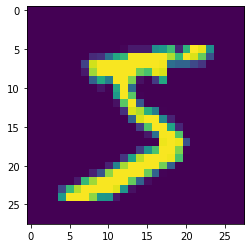

In [5]:
plt.imshow(x_train[0])

In [6]:
# Preprocess data
# Reshape (flatten)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

# Normalize data within {0,1} + dtype conversion
x_train = np.array(x_train/255., dtype=np.float32)
x_test = np.array(x_test/255., dtype=np.float32)

(60000, 784) (10000, 784)


In [7]:
# Function to convert labels to one-hot encodings
def one_hot(Y):
    num_labels = len(set(Y))
    new_Y = []
    for label in Y:
        encoding = np.zeros(num_labels)
        encoding[label] = 1.
        new_Y.append(encoding)
    return np.array(new_Y)

In [8]:
y_train = one_hot(y_train)
y_test = one_hot(y_test)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [9]:
# Layer object to handle weights, biases, activation (if any) of a layer

class Layer:
    def __init__(self, hidden_units: int, activation:str=None):
        self.hidden_units = hidden_units
        self.activation = activation
        self.W = None
        self.b = None
        
    def initialize_params(self, n_in, hidden_units):
        params = dict()
        np.random.seed(42)
        self.W = np.random.randn(n_in, hidden_units) * np.sqrt(2/n_in) 
        np.random.seed(42)
        self.b = np.zeros((1, hidden_units))
    
    def forward(self, X):
        self.input = np.array(X, copy=True)
        if self.W is None:
            self.initialize_params(self.input.shape[-1], self.hidden_units)

        self.Z = X @ self.W + self.b
        
        if self.activation is not None:
            self.A = self.activation_fn(self.Z)
            return self.A
        return self.Z
    
    def activation_fn(self, z, derivative=False):
        if self.activation == 'relu':
            if derivative:
                return self.drelu(z)
            return self.relu(z)
        if self.activation == 'sigmoid':
            if derivative:
                return self.dsigmoid(z)
            return self.sigmoid(z)
        if self.activation == 'softmax':
            if derivative: 
                return self.dsoftmax(z)
            return self.softmax(z)

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dsigmoid(z):
        return Layer.sigmoid(z) * (1-Layer.sigmoid(z))

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def drelu(z):
        return np.where(z<=0,0,1)

    @staticmethod
    def softmax(x):  # numerically stable version of softmax 
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    @staticmethod
    def dsoftmax(x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True)) 
        return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))

    def __repr__(self):
        return str(f'''Hidden Units={self.hidden_units}; Activation={self.activation}''')

In [132]:
class Model:
    def __init__(self):
        self.layers = dict()
        self.cache = dict()
        self.grads = dict()
        
    def add(self, layer):
        self.layers[len(self.layers)+1] = layer
        
    def set_config(self, epochs, alpha, optimizer=None, lr_decay=False):
        self.epochs = epochs
        self.alpha = alpha
        self.optimizer = optimizer
        self.lr_decay = lr_decay

        # below dictionaries used as "cache" for more complicated optimizers
        self.v, self.m = dict(), dict()
        for idx in self.layers.keys():
            self.v[f'W{idx}'] = 0
            self.v[f'b{idx}'] = 0
            self.m[f'W{idx}'] = 0
            self.m[f'b{idx}'] = 0

    def forward(self, x):
        for idx, layer in self.layers.items():
            x = layer.forward(x)
            self.cache[f'W{idx}'] = layer.W
            self.cache[f'Z{idx}'] = layer.Z
            self.cache[f'A{idx}'] = layer.A
        return x

    def backward(self, y):
        last_layer_idx = max(model.layers.keys())
        m = y.shape[0]
        # back prop through all dZs 
        for idx in reversed(range(1, last_layer_idx+1)):
            if idx == last_layer_idx:
                # e.g. dZ3 = y_pred - y_true for a 3 layer network 
                self.grads[f'dZ{idx}'] = self.cache[f'A{idx}'] - y
            else:
                # dZn = dZ(n+1) dot W(n+1) * inverse derivative of activation function of Layer n, with Zn as input 
                self.grads[f'dZ{idx}'] = self.grads[f'dZ{idx+1}'] @ self.cache[f'W{idx+1}'].T * self.layers[idx].activation_fn(self.cache[f'Z{idx}'], derivative=True)
            self.grads[f'dW{idx}'] = 1 / m * self.layers[idx].input.T @ self.grads[f'dZ{idx}']
            self.grads[f'db{idx}'] = 1 / m * np.sum(self.grads[f'dZ{idx}'], axis=0, keepdims=True)
            
            assert self.grads[f'dW{idx}'].shape == self.cache[f'W{idx}'].shape

    def update_params(self, epoch_num, steps):
        for idx in self.layers.keys():
            self.optimize(idx, epoch_num, steps)
 
            
    def fit(self, x_train, y_train, x_test=None, y_test=None, batch_size=32):
        '''Training cycle of the model object'''
        losses = []
        train_accs = []
        val_accs = []

        for i in range(1, self.epochs+1):
            print(f'Epoch {i}')
            batches = self.create_batches(x_train, y_train, batch_size)
            epoch_loss = []
            steps = 0
            
            for x, y in batches:
                steps += 1
                preds = self.forward(x)
                loss = self.compute_loss(y, preds)
                epoch_loss.append(loss)

                # Backward propagation - calculation of gradients 
                self.backward(y)
                
                # update weights and biases of each layer
                self.update_params(i, steps)
                
            loss = sum(epoch_loss) / len(epoch_loss)
            losses.append(loss)

            train_preds = self.forward(x_train)
            c = np.argmax(train_preds, axis=1) == np.argmax(y_train, axis=1)
            train_acc = list(c).count(True) / len(c) * 100
            train_accs.append(train_acc)
                
            if x_test is not None:
                test_preds = self.forward(x_test)
                c = np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)
                val_acc = list(c).count(True)/len(c) * 100
                val_accs.append(val_acc)

                print(f'Loss:{loss} Train Acc: {train_acc} Val Acc: {val_acc}')
                
        self.history = {'train_loss': losses, 'train_acc': train_accs, 'val_acc': val_accs}

    def optimize(self, idx, epoch_num, steps):  
        if self.lr_decay:
            # (optional) learning_rate decays by 0.8 every 5 epochs 
            decay_rate = 0.8
            lr = self.alpha * decay_rate ** int(epoch_num / 5) 
        else:
            lr = self.alpha

        if self.optimizer is None:
            ''' Vanilla mini-batch gradient descent  '''
            self.layers[idx].W -= lr* self.grads[f'dW{idx}']
            self.layers[idx].b -= lr * self.grads[f'db{idx}']

        if self.optimizer == 'momentum':
            '''  Momentum builds up velocity in any direction that has consistent gradient
              Gradient Descent with momentum '''
            max_mu = 0.99
            mu_init = 0.5
            # increase mu by a factor of 1.2 every epoch until max_mu is reached (only applicable for momentum and nesterov momentum)
            mu = min(mu_init * 1.2 ** (epoch_num - 1), max_mu)
            
            self.v[f'W{idx}'] = self.v[f'W{idx}'] * mu - lr * self.grads[f'dW{idx}']
            self.v[f'b{idx}'] = self.v[f'b{idx}'] * mu - lr * self.grads[f'db{idx}']
            self.layers[idx].W += self.v[f'W{idx}']
            self.layers[idx].b += self.v[f'b{idx}']

        if self.optimizer == 'nesterov':
            '''Nesterov's Accelerated Momentum: https://arxiv.org/pdf/1212.0901v2.pdf'''
            max_mu = 0.99
            mu_init = 0.5
            # increase mu by a factor of 1.2 every epoch until max_mu is reached (only applicable for momentum and nesterov momentum)
            mu = min(mu_init * 1.2 ** (epoch_num - 1), max_mu)
            
            vW_prev =  np.array(self.v[f'W{idx}'], copy=True)
            vb_prev = np.array(self.v[f'b{idx}'], copy=True)

            self.v[f'W{idx}'] = self.v[f'W{idx}'] * mu - lr * self.grads[f'dW{idx}']
            self.v[f'b{idx}'] = self.v[f'b{idx}'] * mu - lr * self.grads[f'db{idx}']

            w_update = -mu * vW_prev + (1 + mu) * self.v[f'W{idx}']
            b_update = -mu * vb_prev + (1 + mu) * self.v[f'b{idx}']

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape

            self.layers[idx].W += w_update
            self.layers[idx].b += b_update

        if self.optimizer == 'adagrad':
            '''Adagrad: https://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf'''
            eps = 1e-8
            self.v[f'W{idx}'] += self.grads[f'dW{idx}'] **2 
            self.v[f'b{idx}'] += self.grads[f'db{idx}'] **2

            w_update = - lr * self.grads[f'dW{idx}'] / (np.sqrt(self.v[f'W{idx}'] + eps))
            b_update = - lr * self.grads[f'db{idx}'] / (np.sqrt(self.v[f'b{idx}']+ eps))
            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update

        if self.optimizer == 'adadelta':
            '''Adaptive learning rate method without the need to explicitly set a 
                learning rate : https://arxiv.org/pdf/1212.5701.pdf'''
            eps = 1e-8
            gamma = 0.9

            # squared grad var
            self.v[f'W{idx}'] = gamma * self.v[f'W{idx}'] + (1 - gamma) * self.grads[f'dW{idx}'] ** 2
            self.v[f'b{idx}'] = gamma * self.v[f'b{idx}'] + (1 - gamma) * self.grads[f'db{idx}'] ** 2

            w_update = - np.sqrt(self.m[f'W{idx}'] + eps) / np.sqrt(self.v[f'W{idx}'] + eps) * self.grads[f'dW{idx}'] 
            b_update = - np.sqrt(self.m[f'b{idx}'] + eps) / np.sqrt(self.v[f'b{idx}'] + eps) * self.grads[f'db{idx}'] 

            # grad updates var 
            self.m[f'W{idx}'] = gamma * self.m[f'W{idx}']  + (1 - gamma) * w_update ** 2
            self.m[f'b{idx}'] = gamma * self.m[f'b{idx}']  + (1 - gamma) * b_update ** 2

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update

        if self.optimizer == 'RMSprop':
            eps = 1e-8
            decay_rate = 0.9
            self.v[f'W{idx}'] = decay_rate * self.v[f'W{idx}'] + (1 - decay_rate) * self.grads[f'dW{idx}'] **2 
            self.v[f'b{idx}'] = decay_rate * self.v[f'b{idx}'] + (1 - decay_rate) * self.grads[f'db{idx}'] **2 

            w_update = - lr * self.grads[f'dW{idx}'] / (np.sqrt(self.v[f'W{idx}'] + eps))
            b_update = - lr * self.grads[f'db{idx}'] / (np.sqrt(self.v[f'b{idx}']+ eps))
            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update            
        
        if self.optimizer == 'Adam':
            '''One of the most popular first-order gradient descent algorithms with momentum
                terms : https://arxiv.org/pdf/1412.6980.pdf'''
            eps = 1e-8
            beta1, beta2 = 0.9, 0.999

            self.m[f'W{idx}'] = beta1 * self.m[f'W{idx}'] + (1 - beta1) * self.grads[f'dW{idx}']
            self.v[f'W{idx}'] = beta2 * self.v[f'W{idx}'] + (1 - beta2) * self.grads[f'dW{idx}'] ** 2 

            self.m[f'b{idx}'] = beta1 * self.m[f'b{idx}'] + (1 - beta1) * self.grads[f'db{idx}']
            self.v[f'b{idx}'] = beta2 * self.v[f'b{idx}'] + (1 - beta2) * self.grads[f'db{idx}'] ** 2 

            mt_w  = self.m[f'W{idx}'] / (1 - beta1 ** steps)
            vt_w = self.v[f'W{idx}'] / (1 - beta2 ** steps)

            mt_b  = self.m[f'b{idx}'] / (1 - beta1 ** steps)
            vt_b = self.v[f'b{idx}'] / (1 - beta2 ** steps)

            w_update = - lr * mt_w / (np.sqrt(vt_w) + eps)
            b_update = - lr * mt_b / (np.sqrt(vt_b) + eps)

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update

        if self.optimizer == 'Adamax':
            eps = 1e-8
            beta1, beta2 = 0.9, 0.999

            self.m[f'W{idx}'] = beta1 * self.m[f'W{idx}'] + (1 - beta1) * self.grads[f'dW{idx}']                
            self.v[f'W{idx}'] = np.maximum(beta2 * self.v[f'W{idx}'],  abs(self.grads[f'dW{idx}']))
            self.m[f'b{idx}'] = beta1 * self.m[f'b{idx}'] + (1 - beta1) * self.grads[f'db{idx}']
            self.v[f'b{idx}'] = np.maximum(beta2 * self.v[f'b{idx}'],  abs(self.grads[f'db{idx}']))

            mt_w  = self.m[f'W{idx}'] / (1 - beta1 ** steps)
            vt_w = self.v[f'W{idx}'] / (1 - beta2 ** steps)

            mt_b  = self.m[f'b{idx}'] / (1 - beta1 ** steps)
            vt_b = self.v[f'b{idx}'] / (1 - beta2 ** steps)
            assert steps != 0  # or else it will divide by 0 
            w_update = - (lr / (1 - beta1 ** steps )) * mt_w / (vt_w + eps)
            b_update = - (lr / (1 - beta1 ** steps )) * mt_b / (vt_b + eps) 

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update
        
        if self.optimizer == 'AdamW':
            '''Adam with decoupled weight decay: https://arxiv.org/pdf/1711.05101v3.pdf'''
            eps = 1e-8
            beta1, beta2 = 0.9, 0.999
            gamma_init = 1e-5
            decay_rate = 0.8
            gamma = gamma_init * decay_rate ** int(epoch_num / 5) 

            self.m[f'W{idx}'] = beta1 * self.m[f'W{idx}'] + (1 - beta1) * self.grads[f'dW{idx}']
            self.v[f'W{idx}'] = beta2 * self.v[f'W{idx}'] + (1 - beta2) * self.grads[f'dW{idx}'] ** 2 

            self.m[f'b{idx}'] = beta1 * self.m[f'b{idx}'] + (1 - beta1) * self.grads[f'db{idx}']
            self.v[f'b{idx}'] = beta2 * self.v[f'b{idx}'] + (1 - beta2) * self.grads[f'db{idx}'] ** 2 

            mt_w  = self.m[f'W{idx}'] / (1 - beta1 ** steps)
            vt_w = self.v[f'W{idx}'] / (1 - beta2 ** steps)

            mt_b  = self.m[f'b{idx}'] / (1 - beta1 ** steps)
            vt_b = self.v[f'b{idx}'] / (1 - beta2 ** steps)

            w_update = - lr * mt_w / ((np.sqrt(vt_w) + eps) + gamma * self.layers[idx].W) 
            b_update = - lr * mt_b / ((np.sqrt(vt_b) + eps) + gamma * self.layers[idx].b)

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update

        if self.optimizer == 'DemonAdam':
            '''Decaying Momentum in Adam: https://arxiv.org/pdf/1910.04952v3.pdf'''
            eps = 1e-8
            beta1_init, beta2 = 0.9, 0.999
            p_t = 1 - epoch_num / self.epochs
            beta1 = beta1_init * (p_t / (1 - beta1_init + beta1_init * p_t))
            
            self.m[f'W{idx}'] = beta1 * self.m[f'W{idx}'] + (1 - beta1) * self.grads[f'dW{idx}']
            self.v[f'W{idx}'] = beta2 * self.v[f'W{idx}'] + (1 - beta2) * self.grads[f'dW{idx}'] ** 2 

            self.m[f'b{idx}'] = beta1 * self.m[f'b{idx}'] + (1 - beta1) * self.grads[f'db{idx}']
            self.v[f'b{idx}'] = beta2 * self.v[f'b{idx}'] + (1 - beta2) * self.grads[f'db{idx}'] ** 2 

            mt_w  = self.m[f'W{idx}'] / (1 - beta1 ** steps)
            vt_w = self.v[f'W{idx}'] / (1 - beta2 ** steps)

            mt_b  = self.m[f'b{idx}'] / (1 - beta1 ** steps)
            vt_b = self.v[f'b{idx}'] / (1 - beta2 ** steps)

            w_update = - lr * mt_w / (np.sqrt(vt_w) + eps)
            b_update = - lr * mt_b / (np.sqrt(vt_b) + eps)

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update
            
        if self.optimizer == 'QHAdam':
            '''Replacing momentum estimators in Adam with quasi-hyperbolic terms:
            https://arxiv.org/pdf/1810.06801.pdf'''
            eps = 1e-8
            beta1, beta2 = 0.9, 0.999
            v1, v2 = 0.7, 1

            self.m[f'W{idx}'] = beta1 * self.m[f'W{idx}'] + (1 - beta1) * self.grads[f'dW{idx}']
            self.v[f'W{idx}'] = beta2 * self.v[f'W{idx}'] + (1 - beta2) * self.grads[f'dW{idx}'] ** 2 

            self.m[f'b{idx}'] = beta1 * self.m[f'b{idx}'] + (1 - beta1) * self.grads[f'db{idx}']
            self.v[f'b{idx}'] = beta2 * self.v[f'b{idx}'] + (1 - beta2) * self.grads[f'db{idx}'] ** 2 

            mt_w  = self.m[f'W{idx}'] / (1 - beta1 ** steps)
            vt_w = self.v[f'W{idx}'] / (1 - beta2 ** steps)

            mt_b  = self.m[f'b{idx}'] / (1 - beta1 ** steps)
            vt_b = self.v[f'b{idx}'] / (1 - beta2 ** steps)

            w_update = - lr * ((1-v1) * self.grads[f'dW{idx}'] + v1 * mt_w) / (np.sqrt((1-v2)*self.grads[f'dW{idx}']**2 + v2 * vt_w) + eps)
            b_update = - lr * ((1-v1) * self.grads[f'db{idx}'] + v1 * mt_b) / (np.sqrt((1-v2)*self.grads[f'db{idx}']**2 + v2 * vt_b) + eps)

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update
        
        if self.optimizer == 'DemonAdamW':
            '''Combination of Decaying momentum and weight decoupling as in AdamW'''
            eps = 1e-8
            # Demon Part
            beta1_init, beta2 = 0.9, 0.999
            p_t = 1 - epoch_num / self.epochs
            beta1 = beta1_init * (p_t / (1 - beta1_init + beta1_init * p_t))
            
            # Weight decoupling part
            gamma_init = 1e-5
            decay_rate = 0.8
            gamma = gamma_init * decay_rate ** int(epoch_num / 5) 
            
            self.m[f'W{idx}'] = beta1 * self.m[f'W{idx}'] + (1 - beta1) * self.grads[f'dW{idx}']
            self.v[f'W{idx}'] = beta2 * self.v[f'W{idx}'] + (1 - beta2) * self.grads[f'dW{idx}'] ** 2 

            self.m[f'b{idx}'] = beta1 * self.m[f'b{idx}'] + (1 - beta1) * self.grads[f'db{idx}']
            self.v[f'b{idx}'] = beta2 * self.v[f'b{idx}'] + (1 - beta2) * self.grads[f'db{idx}'] ** 2 

            mt_w  = self.m[f'W{idx}'] / (1 - beta1 ** steps)
            vt_w = self.v[f'W{idx}'] / (1 - beta2 ** steps)

            mt_b  = self.m[f'b{idx}'] / (1 - beta1 ** steps)
            vt_b = self.v[f'b{idx}'] / (1 - beta2 ** steps)

            w_update = - lr * mt_w / ((np.sqrt(vt_w) + eps) + gamma * self.layers[idx].W) 
            b_update = - lr * mt_b / ((np.sqrt(vt_b) + eps) + gamma * self.layers[idx].b)
            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape
            self.layers[idx].W += w_update
            self.layers[idx].b += b_update
            
        if self.optimizer == 'DemonSGDM':
            '''Decaying momentum applied to SGD https://arxiv.org/pdf/1910.04952v3.pdf'''
            beta_init = 0.9
            p_t = 1 - epoch_num / self.epochs
            beta = beta_init * p_t / ((1 - beta_init) + beta_init * p_t)
            
            self.v[f'W{idx}'] = self.v[f'W{idx}'] * beta - lr * self.grads[f'dW{idx}']
            self.v[f'b{idx}'] = self.v[f'b{idx}'] * beta - lr * self.grads[f'db{idx}']
            self.layers[idx].W += self.v[f'W{idx}']
            self.layers[idx].b += self.v[f'b{idx}']
        
        if self.optimizer == 'DemonNesterov':
            '''Decaying momentum applied to Nesterov momentum '''
            beta_init = 0.9
            p_t = 1 - epoch_num / self.epochs
            beta = beta_init * p_t / ((1 - beta_init) + beta_init * p_t)
            
            vW_prev =  np.array(self.v[f'W{idx}'], copy=True)
            vb_prev = np.array(self.v[f'b{idx}'], copy=True)

            self.v[f'W{idx}'] = self.v[f'W{idx}'] * beta - lr * self.grads[f'dW{idx}']
            self.v[f'b{idx}'] = self.v[f'b{idx}'] * beta - lr * self.grads[f'db{idx}']

            w_update = -beta * vW_prev + (1 + beta) * self.v[f'W{idx}']
            b_update = -beta * vb_prev + (1 + beta) * self.v[f'b{idx}']

            assert w_update.shape == self.layers[idx].W.shape
            assert b_update.shape == self.layers[idx].b.shape

            self.layers[idx].W += w_update
            self.layers[idx].b += b_update
        
            
    @staticmethod
    def compute_loss(Y, Y_hat):
        m = Y.shape[0]
        L = -1./m * np.sum(Y * np.log(Y_hat))
        return L

    @staticmethod
    def mse(Y, Y_hat):
        m = Y.shape[0]
        return np.mean((Y- Y_hat)**2)
    
    @staticmethod
    def create_batches(x, y, batch_size):
        m = x.shape[0]
        num_batches = m / batch_size
        batches = []
        for i in range(int(num_batches+1)):
            batch_x = x[i*batch_size:(i+1)*batch_size]
            batch_y = y[i*batch_size:(i+1)*batch_size]
            batches.append((batch_x, batch_y))
        
        if m % batch_size == 0:
            batches.pop(-1)

        return batches
    
    def __repr__(self):
        return str(self.layers)

In [158]:
epochs = 20 
lr_start = 1e-3
batch_size = 128
lr_decay = False

In [161]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer=None, lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
vanilla = model.history

Epoch 1
Loss:2.1503119682928302 Train Acc: 43.27166666666667 Val Acc: 43.63
Epoch 2
Loss:1.789025401127598 Train Acc: 60.99166666666667 Val Acc: 61.86000000000001
Epoch 3
Loss:1.4460175021900223 Train Acc: 69.90666666666667 Val Acc: 70.96000000000001
Epoch 4
Loss:1.1681158313491378 Train Acc: 75.38833333333334 Val Acc: 76.83
Epoch 5
Loss:0.9724806898954285 Train Acc: 78.97333333333333 Val Acc: 80.05
Epoch 6
Loss:0.8376267271694037 Train Acc: 81.15833333333333 Val Acc: 82.41000000000001
Epoch 7
Loss:0.7421259956904581 Train Acc: 82.87166666666667 Val Acc: 84.07
Epoch 8
Loss:0.6719898616919099 Train Acc: 84.08 Val Acc: 85.34
Epoch 9
Loss:0.6186536204666072 Train Acc: 85.055 Val Acc: 86.32
Epoch 10
Loss:0.5768878117558198 Train Acc: 85.79166666666667 Val Acc: 86.89
Epoch 11
Loss:0.5434002606364619 Train Acc: 86.40833333333333 Val Acc: 87.41
Epoch 12
Loss:0.5160244313197698 Train Acc: 86.87 Val Acc: 87.92999999999999
Epoch 13
Loss:0.4932644358199433 Train Acc: 87.29666666666667 Val Acc: 88

In [162]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='momentum',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
momentum = model.history

Epoch 1
Loss:1.971548086743485 Train Acc: 60.940000000000005 Val Acc: 61.78
Epoch 2
Loss:1.250420248838212 Train Acc: 77.28833333333334 Val Acc: 78.38000000000001
Epoch 3
Loss:0.7758959326613197 Train Acc: 84.01666666666667 Val Acc: 85.24000000000001
Epoch 4
Loss:0.5239670911303634 Train Acc: 87.92999999999999 Val Acc: 88.99000000000001
Epoch 5
Loss:0.3382509386365137 Train Acc: 92.72666666666667 Val Acc: 93.05
Epoch 6
Loss:0.2160378233607533 Train Acc: 94.80333333333333 Val Acc: 94.69999999999999
Epoch 7
Loss:0.16188467669077286 Train Acc: 96.2 Val Acc: 96.0
Epoch 8
Loss:0.13054313307258283 Train Acc: 96.65333333333334 Val Acc: 96.34
Epoch 9
Loss:0.1108617285036437 Train Acc: 97.29166666666667 Val Acc: 96.71
Epoch 10
Loss:0.09447141691313259 Train Acc: 97.615 Val Acc: 96.84
Epoch 11
Loss:0.07913496700905819 Train Acc: 97.79666666666667 Val Acc: 96.81
Epoch 12
Loss:0.06897837086191724 Train Acc: 97.925 Val Acc: 96.74000000000001
Epoch 13
Loss:0.06206052102064375 Train Acc: 97.998333333

In [163]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='DemonSGDM',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
DemonSGDM = model.history

Epoch 1
Loss:1.1695748081723347 Train Acc: 84.84 Val Acc: 86.00999999999999
Epoch 2
Loss:0.4815219152400152 Train Acc: 88.53166666666667 Val Acc: 89.5
Epoch 3
Loss:0.3840708349918986 Train Acc: 89.94166666666666 Val Acc: 90.7
Epoch 4
Loss:0.3437184550649107 Train Acc: 90.66833333333332 Val Acc: 91.35
Epoch 5
Loss:0.3193405968850166 Train Acc: 91.23 Val Acc: 91.74
Epoch 6
Loss:0.301813844596415 Train Acc: 91.62666666666667 Val Acc: 92.09
Epoch 7
Loss:0.2881100803189039 Train Acc: 91.995 Val Acc: 92.47999999999999
Epoch 8
Loss:0.27695226100039216 Train Acc: 92.34666666666666 Val Acc: 92.67
Epoch 9
Loss:0.26758527517191877 Train Acc: 92.61666666666667 Val Acc: 92.9
Epoch 10
Loss:0.259602957411795 Train Acc: 92.82000000000001 Val Acc: 93.12
Epoch 11
Loss:0.2527050033766659 Train Acc: 93.01666666666667 Val Acc: 93.34
Epoch 12
Loss:0.24671018318933519 Train Acc: 93.16499999999999 Val Acc: 93.44
Epoch 13
Loss:0.24152454420953665 Train Acc: 93.29166666666666 Val Acc: 93.55
Epoch 14
Loss:0.2370

In [164]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='nesterov',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
nesterov = model.history

Epoch 1
Loss:1.9704602353734222 Train Acc: 60.96666666666667 Val Acc: 61.809999999999995
Epoch 2
Loss:1.2492045883557268 Train Acc: 77.275 Val Acc: 78.41
Epoch 3
Loss:0.7752782565332458 Train Acc: 83.99333333333333 Val Acc: 85.2
Epoch 4
Loss:0.5235083758006135 Train Acc: 87.92 Val Acc: 88.92
Epoch 5
Loss:0.3309839506914328 Train Acc: 92.805 Val Acc: 93.25
Epoch 6
Loss:0.213242561200188 Train Acc: 94.88333333333333 Val Acc: 94.82000000000001
Epoch 7
Loss:0.15996038924505562 Train Acc: 96.18666666666667 Val Acc: 95.88
Epoch 8
Loss:0.12805185070117284 Train Acc: 96.89666666666666 Val Acc: 96.41999999999999
Epoch 9
Loss:0.1072331054825482 Train Acc: 97.37666666666667 Val Acc: 96.69
Epoch 10
Loss:0.09302741390169603 Train Acc: 97.63333333333334 Val Acc: 96.84
Epoch 11
Loss:0.08170495425120991 Train Acc: 97.85166666666667 Val Acc: 96.99
Epoch 12
Loss:0.07074861171046833 Train Acc: 98.08 Val Acc: 97.11
Epoch 13
Loss:0.06088358675288745 Train Acc: 98.24666666666667 Val Acc: 97.06
Epoch 14
Loss

In [165]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='DemonNesterov',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
DemonNesterov = model.history

Epoch 1
Loss:1.1642016084499796 Train Acc: 84.85333333333334 Val Acc: 86.08
Epoch 2
Loss:0.4806458785894338 Train Acc: 88.54833333333333 Val Acc: 89.52
Epoch 3
Loss:0.38362110879260547 Train Acc: 89.93333333333334 Val Acc: 90.74
Epoch 4
Loss:0.3433857232655801 Train Acc: 90.67666666666668 Val Acc: 91.32000000000001
Epoch 5
Loss:0.31904082564565445 Train Acc: 91.21666666666667 Val Acc: 91.74
Epoch 6
Loss:0.3015359503814585 Train Acc: 91.625 Val Acc: 92.06
Epoch 7
Loss:0.28785468308708484 Train Acc: 91.99000000000001 Val Acc: 92.43
Epoch 8
Loss:0.27670844594355565 Train Acc: 92.33 Val Acc: 92.7
Epoch 9
Loss:0.26735741393562656 Train Acc: 92.62166666666667 Val Acc: 92.94
Epoch 10
Loss:0.2593869526325768 Train Acc: 92.83333333333333 Val Acc: 93.11
Epoch 11
Loss:0.2525022200321837 Train Acc: 93.00666666666667 Val Acc: 93.36
Epoch 12
Loss:0.24652098879491402 Train Acc: 93.175 Val Acc: 93.41000000000001
Epoch 13
Loss:0.24135376910101974 Train Acc: 93.28999999999999 Val Acc: 93.54
Epoch 14
Los

In [166]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='adagrad',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
adagrad = model.history

Epoch 1
Loss:0.7171549526428017 Train Acc: 88.02333333333333 Val Acc: 89.16
Epoch 2
Loss:0.4096879870265197 Train Acc: 89.91833333333334 Val Acc: 90.55
Epoch 3
Loss:0.35406859766641036 Train Acc: 90.79333333333334 Val Acc: 91.32000000000001
Epoch 4
Loss:0.32509927665763605 Train Acc: 91.33666666666667 Val Acc: 91.75
Epoch 5
Loss:0.3060792596133649 Train Acc: 91.77499999999999 Val Acc: 92.08
Epoch 6
Loss:0.2920151079142119 Train Acc: 92.07833333333333 Val Acc: 92.31
Epoch 7
Loss:0.28087703721807444 Train Acc: 92.33166666666666 Val Acc: 92.54
Epoch 8
Loss:0.2716394642224041 Train Acc: 92.56833333333333 Val Acc: 92.75
Epoch 9
Loss:0.26368003793973244 Train Acc: 92.77166666666666 Val Acc: 92.89
Epoch 10
Loss:0.256737689077106 Train Acc: 92.94333333333333 Val Acc: 93.07
Epoch 11
Loss:0.25056972265669597 Train Acc: 93.09333333333333 Val Acc: 93.28
Epoch 12
Loss:0.245026033828067 Train Acc: 93.24 Val Acc: 93.39
Epoch 13
Loss:0.2399862082601527 Train Acc: 93.35666666666667 Val Acc: 93.60000000

In [167]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='adadelta',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
adadelta = model.history

Epoch 1
Loss:0.5216086513178354 Train Acc: 91.545 Val Acc: 92.02
Epoch 2
Loss:0.24868579997920504 Train Acc: 93.73666666666666 Val Acc: 93.67
Epoch 3
Loss:0.19593791375004146 Train Acc: 94.94666666666667 Val Acc: 94.87
Epoch 4
Loss:0.163083112791142 Train Acc: 95.74000000000001 Val Acc: 95.47
Epoch 5
Loss:0.14034661366835155 Train Acc: 96.31666666666666 Val Acc: 95.94
Epoch 6
Loss:0.12333075344112854 Train Acc: 96.77333333333334 Val Acc: 96.28
Epoch 7
Loss:0.1102290358722389 Train Acc: 97.14833333333334 Val Acc: 96.61
Epoch 8
Loss:0.09958047746801861 Train Acc: 97.43666666666667 Val Acc: 96.78
Epoch 9
Loss:0.09069253088535276 Train Acc: 97.66166666666666 Val Acc: 96.99
Epoch 10
Loss:0.08318852952109285 Train Acc: 97.82333333333332 Val Acc: 97.09
Epoch 11
Loss:0.07670058435172007 Train Acc: 97.95 Val Acc: 97.22
Epoch 12
Loss:0.07106781612803836 Train Acc: 98.125 Val Acc: 97.26
Epoch 13
Loss:0.06610386822121951 Train Acc: 98.24333333333334 Val Acc: 97.31
Epoch 14
Loss:0.06172825657555605

In [168]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='RMSprop', lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
RMSprop = model.history

Epoch 1
Loss:0.3112406564104391 Train Acc: 93.82666666666667 Val Acc: 93.83
Epoch 2
Loss:0.1365898929439944 Train Acc: 95.74166666666667 Val Acc: 95.53
Epoch 3
Loss:0.09523743957556063 Train Acc: 96.6 Val Acc: 96.0
Epoch 4
Loss:0.07248649986327013 Train Acc: 97.29333333333334 Val Acc: 96.47
Epoch 5
Loss:0.05731829096690027 Train Acc: 97.83833333333334 Val Acc: 96.89
Epoch 6
Loss:0.04605225146866969 Train Acc: 98.22166666666666 Val Acc: 97.19
Epoch 7
Loss:0.03685436574078377 Train Acc: 98.59333333333333 Val Acc: 97.39999999999999
Epoch 8
Loss:0.029978551463028705 Train Acc: 98.66666666666667 Val Acc: 97.35000000000001
Epoch 9
Loss:0.024523964547404263 Train Acc: 98.80333333333333 Val Acc: 97.42
Epoch 10
Loss:0.020361098971166898 Train Acc: 99.03666666666666 Val Acc: 97.54
Epoch 11
Loss:0.017155416511483806 Train Acc: 99.005 Val Acc: 97.39
Epoch 12
Loss:0.013729861192076259 Train Acc: 99.12166666666667 Val Acc: 97.35000000000001
Epoch 13
Loss:0.012077027642831431 Train Acc: 99.2066666666

In [169]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='Adam',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
Adam = model.history

Epoch 1
Loss:0.34624059333092777 Train Acc: 94.435 Val Acc: 94.15
Epoch 2
Loss:0.14825623941078148 Train Acc: 96.23833333333334 Val Acc: 95.71
Epoch 3
Loss:0.11145417180169578 Train Acc: 97.12833333333334 Val Acc: 96.46000000000001
Epoch 4
Loss:0.08935200043307788 Train Acc: 97.67166666666667 Val Acc: 96.72
Epoch 5
Loss:0.07398113188749977 Train Acc: 98.00666666666666 Val Acc: 96.91
Epoch 6
Loss:0.06255578133234581 Train Acc: 98.21833333333333 Val Acc: 97.06
Epoch 7
Loss:0.05367491966493914 Train Acc: 98.42 Val Acc: 97.18
Epoch 8
Loss:0.04643268179420983 Train Acc: 98.58666666666667 Val Acc: 97.24000000000001
Epoch 9
Loss:0.0401502688351156 Train Acc: 98.67 Val Acc: 97.26
Epoch 10
Loss:0.03492799950511688 Train Acc: 98.7 Val Acc: 97.27
Epoch 11
Loss:0.030460472903013912 Train Acc: 98.89666666666666 Val Acc: 97.35000000000001
Epoch 12
Loss:0.026486564063315152 Train Acc: 98.96000000000001 Val Acc: 97.32
Epoch 13
Loss:0.023012764999635223 Train Acc: 99.21833333333333 Val Acc: 97.46000000

In [170]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='Adamax',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
Adamax = model.history

Epoch 1
Loss:1.3882072711887488 Train Acc: 86.12666666666667 Val Acc: 87.3
Epoch 2
Loss:0.4592084660934654 Train Acc: 89.67666666666668 Val Acc: 90.56
Epoch 3
Loss:0.3531753695219789 Train Acc: 91.08333333333334 Val Acc: 91.59
Epoch 4
Loss:0.30761378067950385 Train Acc: 91.97666666666666 Val Acc: 92.35
Epoch 5
Loss:0.2787598133094216 Train Acc: 92.61 Val Acc: 92.99
Epoch 6
Loss:0.2571553470956499 Train Acc: 93.14333333333333 Val Acc: 93.47999999999999
Epoch 7
Loss:0.23938363252245923 Train Acc: 93.60333333333334 Val Acc: 93.81
Epoch 8
Loss:0.22425914754146434 Train Acc: 94.01833333333333 Val Acc: 94.04
Epoch 9
Loss:0.2112139834034975 Train Acc: 94.34166666666667 Val Acc: 94.36
Epoch 10
Loss:0.19980202596668398 Train Acc: 94.64666666666666 Val Acc: 94.62
Epoch 11
Loss:0.1897602969881926 Train Acc: 94.89166666666667 Val Acc: 94.87
Epoch 12
Loss:0.18085804369809824 Train Acc: 95.12666666666667 Val Acc: 95.07
Epoch 13
Loss:0.17287640880367106 Train Acc: 95.34666666666666 Val Acc: 95.21
Epo

In [171]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='AdamW',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
AdamW = model.history

Epoch 1
Loss:0.34693777097493633 Train Acc: 94.52000000000001 Val Acc: 94.31
Epoch 2
Loss:0.1488490048492696 Train Acc: 96.09333333333333 Val Acc: 95.62
Epoch 3
Loss:0.11159587537012475 Train Acc: 97.095 Val Acc: 96.44
Epoch 4
Loss:0.0891733326214939 Train Acc: 97.72 Val Acc: 96.81
Epoch 5
Loss:0.07358275141546555 Train Acc: 98.03 Val Acc: 97.0
Epoch 6
Loss:0.0620658785384294 Train Acc: 98.25500000000001 Val Acc: 97.07000000000001
Epoch 7
Loss:0.05303920198505946 Train Acc: 98.45166666666667 Val Acc: 97.17
Epoch 8
Loss:0.04586183019791281 Train Acc: 98.575 Val Acc: 97.23
Epoch 9
Loss:0.03975036610130255 Train Acc: 98.75166666666667 Val Acc: 97.27
Epoch 10
Loss:0.03445315512520775 Train Acc: 98.845 Val Acc: 97.23
Epoch 11
Loss:0.029861953742705956 Train Acc: 98.77333333333334 Val Acc: 97.1
Epoch 12
Loss:0.02617570811801098 Train Acc: 98.75500000000001 Val Acc: 96.93
Epoch 13
Loss:0.022752301635561162 Train Acc: 99.01666666666667 Val Acc: 97.09
Epoch 14
Loss:0.01991587680840194 Train Acc

In [172]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='DemonAdam',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
DemonAdam = model.history

Epoch 1
Loss:0.34525525726787065 Train Acc: 94.59833333333333 Val Acc: 94.27
Epoch 2
Loss:0.14732157574524915 Train Acc: 96.05166666666666 Val Acc: 95.49
Epoch 3
Loss:0.11051390974017611 Train Acc: 97.03333333333333 Val Acc: 96.47
Epoch 4
Loss:0.08838121951405653 Train Acc: 97.60666666666667 Val Acc: 96.78999999999999
Epoch 5
Loss:0.07312186593982441 Train Acc: 97.955 Val Acc: 96.89999999999999
Epoch 6
Loss:0.06158788856300335 Train Acc: 98.15166666666667 Val Acc: 97.03
Epoch 7
Loss:0.05276522536682005 Train Acc: 98.41666666666666 Val Acc: 97.21
Epoch 8
Loss:0.04539148578620157 Train Acc: 98.65833333333333 Val Acc: 97.25
Epoch 9
Loss:0.0392544334274763 Train Acc: 98.82666666666667 Val Acc: 97.38
Epoch 10
Loss:0.03391315881523364 Train Acc: 99.04666666666667 Val Acc: 97.44
Epoch 11
Loss:0.02937219519817275 Train Acc: 99.14833333333334 Val Acc: 97.50999999999999
Epoch 12
Loss:0.025526659775357965 Train Acc: 99.17166666666667 Val Acc: 97.46000000000001
Epoch 13
Loss:0.022093906670588394 T

In [173]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='QHAdam',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
QHAdam = model.history

Epoch 1
Loss:0.3235197321582867 Train Acc: 94.97 Val Acc: 94.78999999999999
Epoch 2
Loss:0.13689962448749754 Train Acc: 96.49333333333333 Val Acc: 96.0
Epoch 3
Loss:0.10244087740565229 Train Acc: 97.25333333333333 Val Acc: 96.55
Epoch 4
Loss:0.08258346578335488 Train Acc: 97.70833333333333 Val Acc: 96.89
Epoch 5
Loss:0.06885005530345191 Train Acc: 98.07666666666667 Val Acc: 97.06
Epoch 6
Loss:0.05838936294978799 Train Acc: 98.28166666666667 Val Acc: 97.18
Epoch 7
Loss:0.05008741167243996 Train Acc: 98.495 Val Acc: 97.21
Epoch 8
Loss:0.043231249230389554 Train Acc: 98.65 Val Acc: 97.25
Epoch 9
Loss:0.03740356407496637 Train Acc: 98.815 Val Acc: 97.36
Epoch 10
Loss:0.032358490016753984 Train Acc: 98.96666666666667 Val Acc: 97.37
Epoch 11
Loss:0.027981835529313402 Train Acc: 99.08333333333333 Val Acc: 97.43
Epoch 12
Loss:0.024237164699674095 Train Acc: 99.21166666666666 Val Acc: 97.43
Epoch 13
Loss:0.020900870355940685 Train Acc: 99.25833333333334 Val Acc: 97.44
Epoch 14
Loss:0.0180250710

In [174]:
model = Model()
model.add(Layer(128, activation='relu'))
model.add(Layer(64, activation='relu'))
model.add(Layer(10, activation='softmax'))
model.set_config(epochs=epochs, alpha=lr_start, optimizer='DemonAdamW',lr_decay=lr_decay)
model.fit(x_train, y_train, x_test, y_test, batch_size=batch_size)
DemonAdamW = model.history

Epoch 1
Loss:0.3466096925089451 Train Acc: 94.63000000000001 Val Acc: 94.42
Epoch 2
Loss:0.14803258841396658 Train Acc: 96.11666666666666 Val Acc: 95.5
Epoch 3
Loss:0.11072932136290548 Train Acc: 97.11833333333333 Val Acc: 96.52
Epoch 4
Loss:0.0885864731584125 Train Acc: 97.65166666666667 Val Acc: 96.88
Epoch 5
Loss:0.07329138452387216 Train Acc: 98.02666666666666 Val Acc: 97.11
Epoch 6
Loss:0.06192593411986874 Train Acc: 98.28833333333333 Val Acc: 97.21
Epoch 7
Loss:0.052738580067773363 Train Acc: 98.52499999999999 Val Acc: 97.37
Epoch 8
Loss:0.04525772289855424 Train Acc: 98.72833333333332 Val Acc: 97.39
Epoch 9
Loss:0.03917564947688579 Train Acc: 98.86166666666666 Val Acc: 97.47
Epoch 10
Loss:0.03580128426660475 Train Acc: 99.06833333333334 Val Acc: 97.47
Epoch 11
Loss:0.02903739373850233 Train Acc: 99.17166666666667 Val Acc: 97.49
Epoch 12
Loss:0.025051853838685707 Train Acc: 99.24833333333333 Val Acc: 97.53
Epoch 13
Loss:0.021577411668582847 Train Acc: 99.33 Val Acc: 97.52
Epoch 1

In [175]:
num_epochs = [i for i in range(model.epochs)]
fig = go.Figure()
fig.add_trace(go.Scatter(x=num_epochs, y=vanilla['train_loss'], name='Minibatch GD'))
fig.add_trace(go.Scatter(x=num_epochs, y=momentum['train_loss'], name='Momentum'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonSGDM['train_loss'], name='DemonSGDM'))
fig.add_trace(go.Scatter(x=num_epochs, y=nesterov['train_loss'], name='Nesterov Momentum'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonNesterov['train_loss'], name='Demon Nesterov'))
fig.add_trace(go.Scatter(x=num_epochs, y=adagrad['train_loss'], name='Adagrad'))
fig.add_trace(go.Scatter(x=num_epochs, y=adadelta['train_loss'], name='Adadelta'))
fig.add_trace(go.Scatter(x=num_epochs, y=RMSprop['train_loss'], name='RMSprop'))
fig.add_trace(go.Scatter(x=num_epochs, y=Adam['train_loss'], name='Adam'))
fig.add_trace(go.Scatter(x=num_epochs, y=Adamax['train_loss'], name='Adamax'))
fig.add_trace(go.Scatter(x=num_epochs, y=AdamW['train_loss'], name='AdamW'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonAdam['train_loss'], name='DemonAdam'))
fig.add_trace(go.Scatter(x=num_epochs, y=QHAdam['train_loss'], name='QHAdam'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonAdamW['train_loss'], name='DemonAdamW'))

In [176]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=num_epochs, y=vanilla['val_acc'], name='Minibatch GD'))
fig.add_trace(go.Scatter(x=num_epochs, y=momentum['val_acc'], name='Momentum'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonSGDM['val_acc'], name='DemonSGDM'))
fig.add_trace(go.Scatter(x=num_epochs, y=nesterov['val_acc'], name='Nesterov Momentum'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonNesterov['val_acc'], name='Demon Nesterov'))
fig.add_trace(go.Scatter(x=num_epochs, y=adagrad['val_acc'], name='Adagrad'))
fig.add_trace(go.Scatter(x=num_epochs, y=adadelta['val_acc'], name='Adadelta'))
fig.add_trace(go.Scatter(x=num_epochs, y=RMSprop['val_acc'], name='RMSprop'))
fig.add_trace(go.Scatter(x=num_epochs, y=Adam['val_acc'], name='Adam'))
fig.add_trace(go.Scatter(x=num_epochs, y=Adamax['val_acc'], name='Adamax'))
fig.add_trace(go.Scatter(x=num_epochs, y=AdamW['val_acc'], name='AdamW'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonAdam['val_acc'], name='DemonAdam'))
fig.add_trace(go.Scatter(x=num_epochs, y=QHAdam['val_acc'], name='QHAdam'))
fig.add_trace(go.Scatter(x=num_epochs, y=DemonAdamW['val_acc'], name='DemonAdamW'))


In [177]:
preds = model.forward(x_test)

In [178]:
preds = np.argmax(preds, axis=1)

In [179]:
acc = preds == np.argmax(y_test, axis=1)
pred_bool = preds != np.argmax(y_test, axis=1)

In [180]:
accuracy = list(acc).count(True)/len(acc)
print(f'{accuracy=}')

accuracy=0.9676


NN predicted: 4, Label: 6


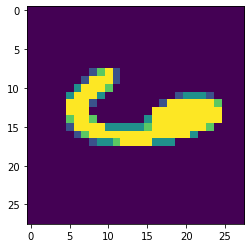

In [194]:
# Example of wrong prediction
idx = np.random.choice(np.where(pred_bool==True)[0])

plt.imshow(x_test[idx].reshape(28,28))
print(f'NN predicted: {preds[idx]}, Label: {np.argmax(y_test[idx])}')

In [ ]:
# can't fault the NN for that one 